## Comparing US Homicides with Developed G20 Nations

Hereby, we can observe an independant look on how to obtain free booze by using basic statistics, open source data and abundance of free time. This study aims to analyze and compare homicide rates (both gun-related and total) in the United States with other developed countries within the G20, using Human Development Index (HDI) as a measure of development. Our hypothesis is that the United States will exhibit a significantly higher homicide rate per 100,000 inhabitants compared to its developed counterparts.

### Motivation:

- The United States stands out within the G20 by consistently registering significantly higher homicide rates than other developed nations.
- Understanding the potential factors contributing to this disparity can inform public policy discussions and potentially guide interventions to reduce violence.
- Bets and booze motivated entirely by a happy US taxpayer.


### Data and Methodology:

- We will utilize relevant datasets on homicides (total and gun-related), population figures, and HDI rankings for G20 member countries.
- Statistical analyses will be employed to compare homicide rates across countries, taking into account HDI levels and potentially controlling for other relevant factors.
- Visualization techniques like boxplots and scatter plots will be used to showcase the relationships between variables.

### Expected Outcomes:

- This analysis aims to provide empirical evidence supporting or refuting the hypothesis.
- It will contribute to a deeper understanding of the complex issue of violent crime in the United States relative to its developed peers.

### Limitations:

- Data availability and quality can influence the analysis.
- Controlling for all potential confounding factors was not fully possible.
- Generalizability of findings to broader populations must be carefully considered.
- Overall, this study aims to shed light on the concerningly high homicide rates in the United States compared to other developed nations within the G20. 

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry

# As per xlsx file, ignore the first 5 rows, use only the first 3 columns
HDI_Countries_df = pd.read_excel('UN-HDI Classification.xlsx', sheet_name=1, engine='openpyxl', skiprows=5, usecols =[0, 1, 2])

# Rename column and drop first 2 rows, drop if NAN in 2021
HDI_Countries_df.rename(columns={"Value": "2021"}, inplace=True)
HDI_Countries_df.drop([0, 1], inplace=True)
HDI_Countries_df.dropna(subset=["HDI rank"], inplace=True)

# Create a new column 'country_code' and apply the function to each country name
C_list = HDI_Countries_df['Country'].tolist()

#Obtain ISO-3 Country Codes, obtain Unknown Codes and manually create outliers
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in C_list]

index_UNK = [i for i, value in enumerate(codes) if value == "Unknown code"]

NAC_list = [C_list[i] for i in index_UNK]

Man_Codes = ['HKG', 'KOR', 'IRN', 'MDA', 'BOL', 'VEN', 'FSM', 'SWZ', 'TZA', 'COD']

# Replace values inside a list
def replace_values(main, index_list, codes):
  """
  Replaces values in a list at specified indices with values from another list.

  Args:
    main: The main list to modify.
    index_list: A list of indices to replace values in.
    codes: A list of values to replace with.

  Returns:
    A new list with the replaced values.
  """

  # Create a copy of the main list to avoid modifying the original.
  new_main = main[:]

  # Loop through the indices and replace values.
  for i, index in enumerate(index_list):
    if 0 <= index < len(new_main):  # Ensure index is within bounds
      new_main[index] = codes[i]

  return new_main

Country_Code_Final = replace_values(codes, index_UNK, Man_Codes)

HDI_Countries_df['Country Code'] = Country_Code_Final

HDI_Countries_df['HDI rank'] = HDI_Countries_df['HDI rank'].astype('int16')

HDI_Countries_df['2021'] = HDI_Countries_df['2021'].astype('float16')


Now that the EDA is complete for the first DataFrame, let's move on the next one.

Note that the following dataset defines intentional homicides as follows:

Intentional homicides are estimates of unlawful homicides purposely inflicted as a result of domestic disputes, interpersonal violence, violent conflicts over land resources, intergang violence over turf or control, and predatory violence and killing by armed groups. Intentional homicide does not include all intentional killing; the difference is usually in the organization of the killing. Individuals or small groups usually commit homicide, whereas killing in armed conflict is usually committed by fairly cohesive groups of up to several hundred members and is thus usually excluded.

In [216]:
#Import the csv of intentional homicides per 100K
Hom_Per_100k = pd.read_csv('UN-Homicides per 100k .csv', header=2)

# The scope of this study ranges from 1990 to 2021, dropping irrelevant columns
Hom_Per_100k.dropna(axis=1, how='all', inplace = True)
Hom_Per_100k.drop(['Indicator Name', 'Indicator Code'], axis= 1,  inplace = True)

Now that the EDA is complete for the second one, we're moving to the third and final argument, intentional homicide with firearms.

In [217]:
UN_Hom_Firearm = pd.read_excel('UN-CTS-Intentional Homicide Firearm.xlsx', engine='openpyxl', skiprows=2)

#Drop unnecessary columns, changing type to category where it applies
UN_Hom_Firearm.drop(['Region', 'Subregion', 'Dimension', 'Sex', 'Age', 'Source'], axis=1, inplace= True)
columns_to_change = ['Indicator', 'Category', 'Unit of measurement']
UN_Hom_Firearm[columns_to_change] = UN_Hom_Firearm[columns_to_change].astype('category')

#Filtering incidents where the category of the Intentional homicide is Firearms or explosives - firearms, the value is equal to Rate per 100,000 population and the indicator is Victims of intentional homicide
UN_Hom_Firearm = UN_Hom_Firearm[
  (UN_Hom_Firearm["Category"] == "Firearms or explosives - firearms") &
  (UN_Hom_Firearm["Unit of measurement"] == "Rate per 100,000 population") & (UN_Hom_Firearm['Indicator'] == 'Victims of intentional homicide')
]

EDA complete for the third part. Moving on to filtering the second and third dataframes based on countries with HDI equal or higher to 0.8 (Developed Nations as per the UN)

In [218]:
#Obtain the country codes for Developed Nations
Country_Filter = HDI_Countries_df[HDI_Countries_df['2021'] >= 0.8]['Country Code'].tolist()

#Filtering the first database based on DN.
Hom_Per_100k_Filtered = Hom_Per_100k[Hom_Per_100k['Country Code'].isin(Country_Filter)]

#Filtering the third database based on DN
UN_Hom_Firearm_Filtered = UN_Hom_Firearm[UN_Hom_Firearm['Iso3_code'].isin(Country_Filter)]

Prepare for the graphs. Note that where a value was not available for any country, the mean across the range of years (1990 to 2021) was inserted.

C:\Users\juanc\AppData\Local\Temp\ipykernel_6384\587156174.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hom_Per_100k_Filtered[year_columns] = Hom_Per_100k_Filtered[year_columns].apply(fill_row_mean_selected_columns, axis=1)
C:\Users\juanc\AppData\Local\Temp\ipykernel_6384\587156174.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hom_Per_100k_Filtered['Tot_Mean'] = Hom_Per_100k_Filtered[year_columns].mean(axis=1)


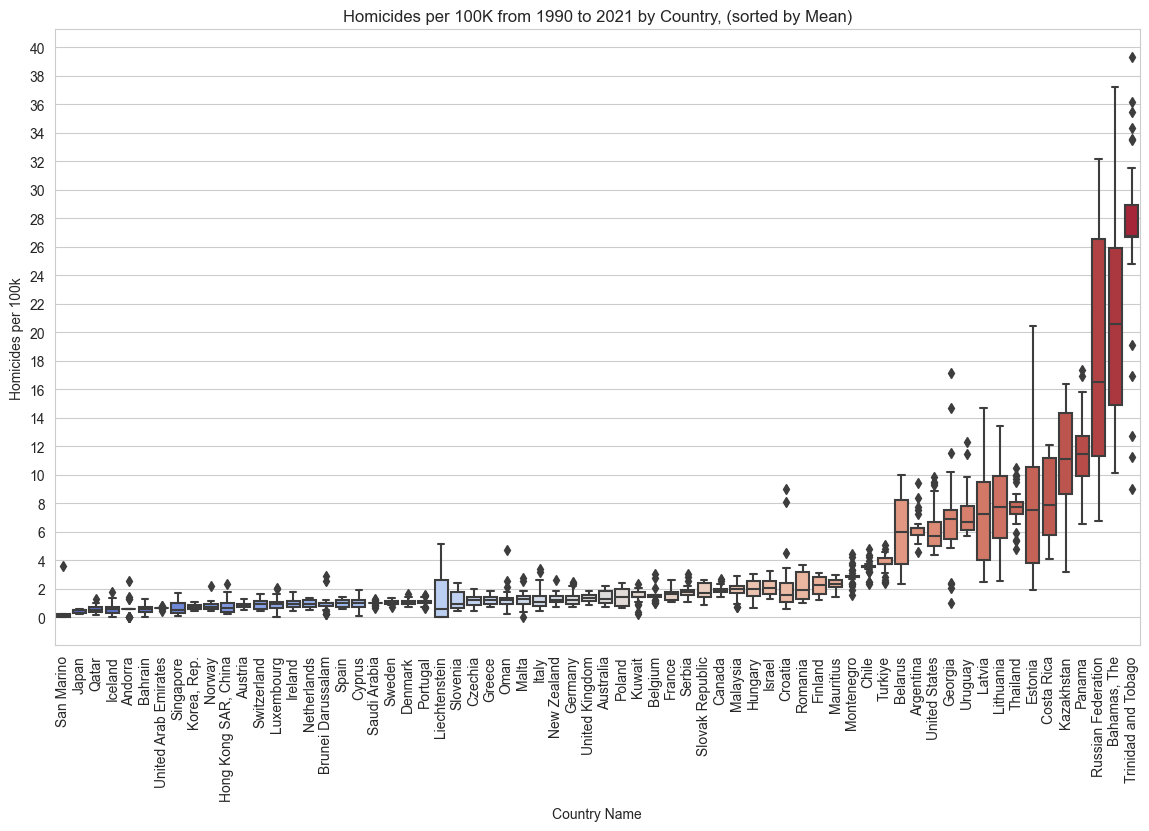

In [219]:
#Filter for columns within range, insert the mean of the numeric values available where NAN exists
year_columns = [f"{year}" for year in range(1990, 2022)]

def fill_row_mean_selected_columns(row):
    means = row[year_columns].mean()  # Calculate mean only for year columns
    return row[year_columns].mask(row[year_columns].isna(), means)

Hom_Per_100k_Filtered[year_columns] = Hom_Per_100k_Filtered[year_columns].apply(fill_row_mean_selected_columns, axis=1)

# Calculate the mean across the year_columns
Hom_Per_100k_Filtered['Tot_Mean'] = Hom_Per_100k_Filtered[year_columns].mean(axis=1)

# Sort the DataFrame based on Tot_Mean
Hom_Per_100k_Filtered_sorted = Hom_Per_100k_Filtered.sort_values(by='Tot_Mean')

# Melt the DataFrame for seaborn
melted_df = Hom_Per_100k_Filtered_sorted.melt(id_vars=['Country Name', 'Tot_Mean'], value_vars=year_columns,
                                              var_name='Year', value_name='Hom_Per_100k')

# Create a boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Country Name', y='Hom_Per_100k', data=melted_df,  palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel('Homicides per 100k')
plt.title('Homicides per 100K from 1990 to 2021 by Country, (sorted by Mean)')
plt.yticks(range(0, 41, 2))
plt.show()

While The US is not the absolut winner, the countries accompaning and or surpassing the amount of homicides per 100.000 habitants have specific considerations like the Russian Federation and its ongoing war with Ukraine, Central American and Caribbean countries with known history of violence. This is visible when comparing the results of the US with the G20, where most of its peers lay way below its mark.

Since not all countries have data within the range of interest, the mean is to be inserted for each country where data is available. 

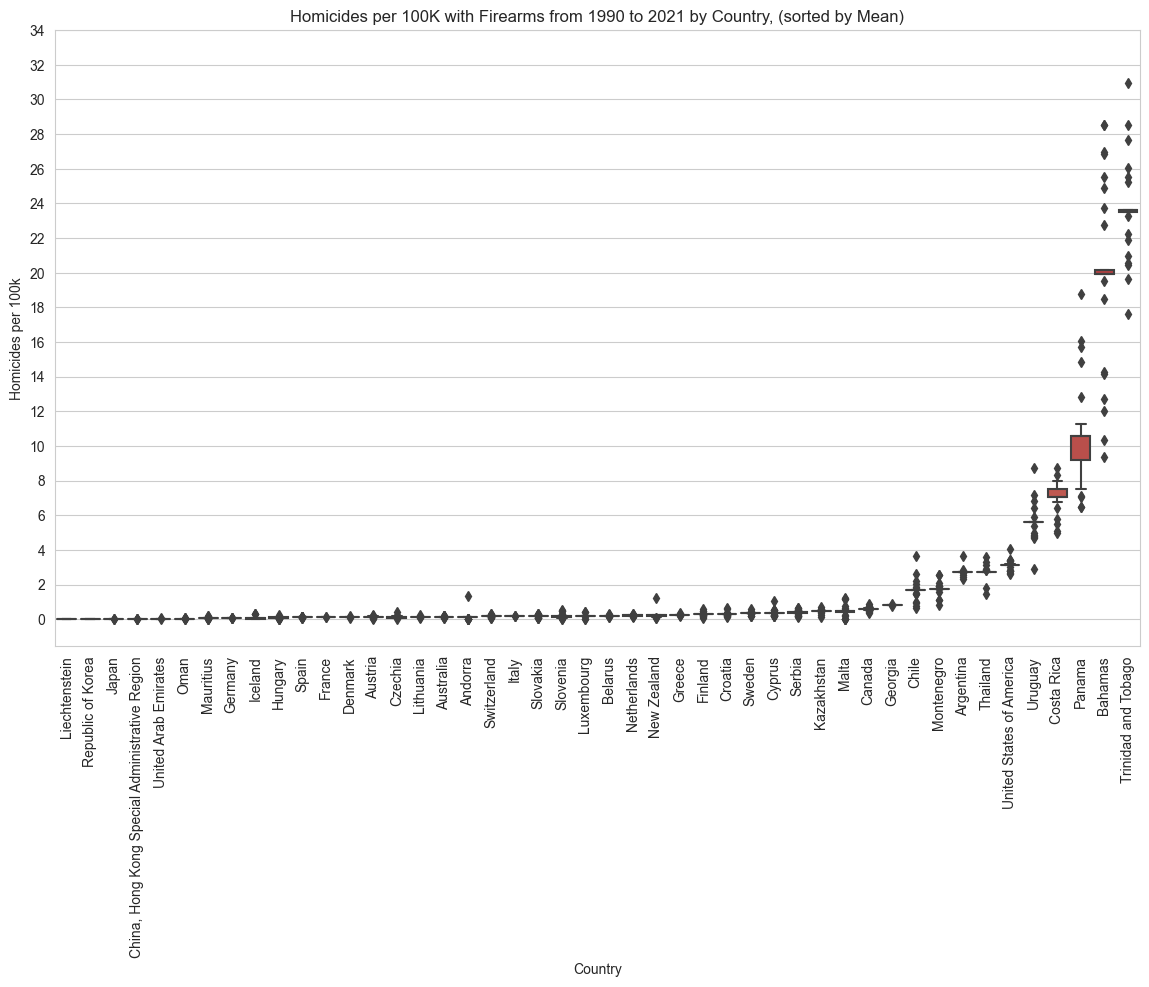

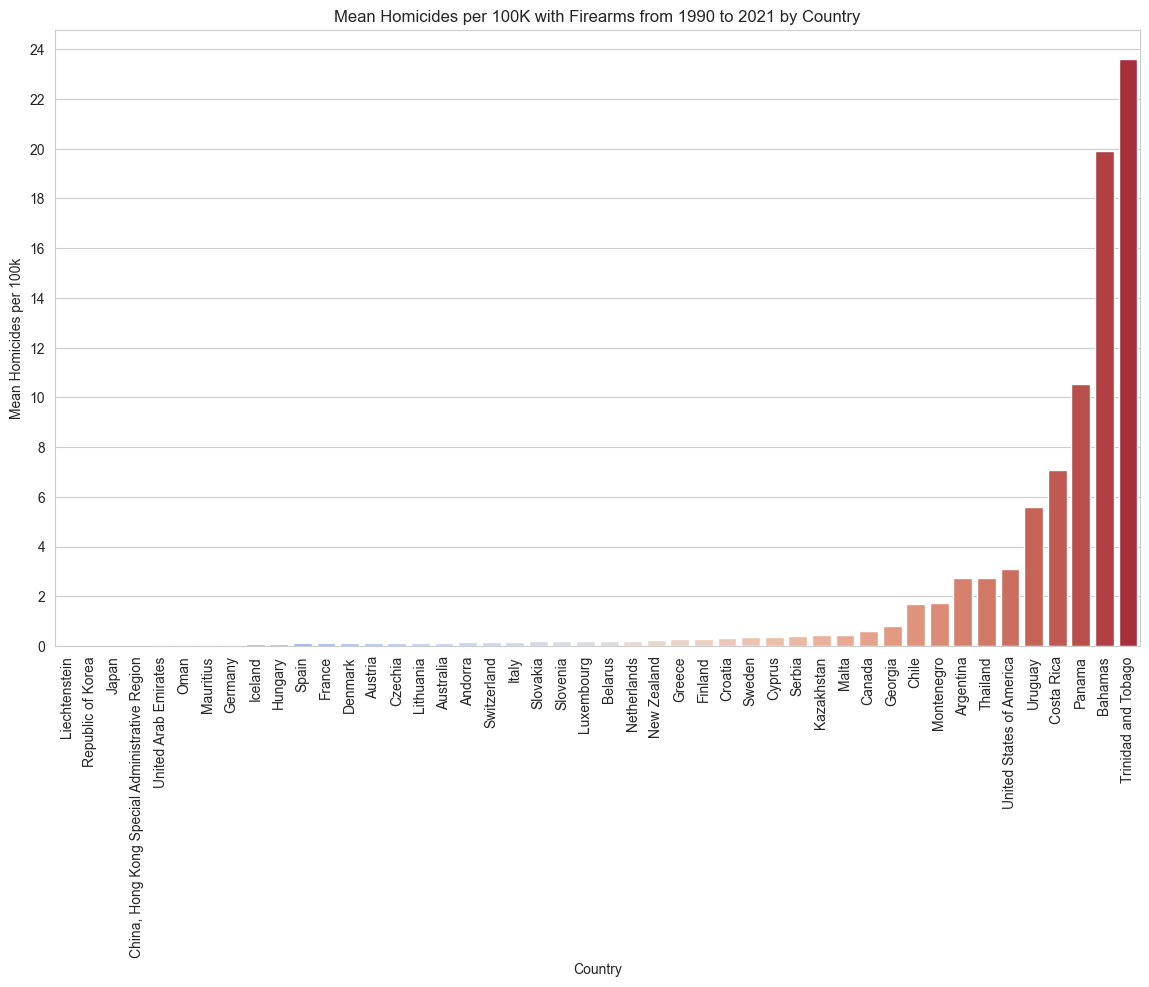

In [220]:
# Step 1: Calculate the mean of each country
mean_per_country = UN_Hom_Firearm_Filtered.groupby('Country')['VALUE'].mean().reset_index()
mean_per_country.columns = ['Country', 'Mean_VALUE']

# Step 2: Ensure each country has entries for the years 1990 to 2021
years_to_fill = [str(year) for year in range(1990, 2022)]

df_filled = pd.DataFrame()

for country, group in UN_Hom_Firearm_Filtered.groupby('Country'):
    # Check if all years are present for the country
    missing_years = set(years_to_fill) - set(group['Year'].astype(str))
    
    # If there are missing years, create copies of rows and insert mean for VALUE
    if missing_years:
        for year in missing_years:
            new_row = group.iloc[0].copy()  # Create a copy of the first row (you can adjust based on your data)
            new_row['Year'] = int(year)
            new_row['VALUE'] = mean_per_country.loc[mean_per_country['Country'] == country, 'Mean_VALUE'].values[0]
            df_filled = pd.concat([df_filled, new_row.to_frame().T], ignore_index=True)
    
    # Concatenate the original rows for the country
    df_filled = pd.concat([df_filled, group], ignore_index=True)

# Convert 'Year' column to int for sorting
df_filled['Year'] = df_filled['Year'].astype(int)

# Sort the DataFrame by 'Country' and 'Year'
df_filled = df_filled.sort_values(by=['Country', 'Year']).reset_index(drop=True)

country_means = df_filled.groupby('Country')['VALUE'].mean()
country_means_df = country_means.to_frame().reset_index().sort_values(by='VALUE')

# Sort df1 based on the order of Country in df2
sorting_order = country_means_df['Country'].unique().tolist()
df_filled_sorted = df_filled.set_index('Country').loc[sorting_order].reset_index()


# Create a boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Country', y='VALUE', data=df_filled_sorted,  palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel('Homicides per 100k')
plt.title('Homicides per 100K with Firearms from 1990 to 2021 by Country, (sorted by Mean)')
plt.yticks(range(0, 35, 2))
plt.show()

# Create a boxplot
plt.figure(figsize=(14, 8))
sns.barplot(x='Country', y='VALUE', data=country_means_df,  palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel('Mean Homicides per 100k')
plt.title('Mean Homicides per 100K with Firearms from 1990 to 2021 by Country')
plt.yticks(range(0, 25, 2))
plt.show()


Once again, when comparing the G20 with the US, it shows a clear disparity over the amount of people unalived by firearms from 1990 to 2021. Some considerations in this plot, like before, the countries are organized by the Human Develop Index, which takes into account several factors, including GDP per capita, Gini coefficient, life expectancy, schooling years, inequality, etc.

#### Incidents and fatalities in developed countries ####

"Finally, this work considered the number of mass shooting incidents and fatalities in developed countries (RQ3). Of these 36 countries, half did not have a single mass shooting between 1998 and 2019. As shown in Figure 1, only ten developed countries had more than one mass shooting: Belgium (n = 2), Czech Republic (n = 2), Italy (n = 2), Netherlands (n = 2), Switzerland (n = 2), Finland (n = 3), Canada (n = 4), Germany (n = 5), France (n = 8), and the US (n = 101). The US had more than 12 times as many mass shootings as the country with the second-highest mass shooting count. As shown in Figure 2, the US also had the greatest number of mass shooting fatalities (n = 816). Only five other developed countries had more than 20 fatalities: Finland (n = 23), Germany (n = 49), New Zealand (n = 51), Norway (n = 77), and France (n = 179)." Jason R Silva (2023)


* Figure 1. Number of mass shootings in developed countries

![Number of mass shootings in developed countries](rcac_a_2052126_f0001_oc.jpg)





* Figure 2. Number of mass shooting fatalities in developed countries

![Number of mass shooting fatalities in developed countries](rcac_a_2052126_f0002_oc.jpg)



#### Sources ####

- https://dataunodc.un.org/dp-intentional-homicide-victims

- https://hdr.undp.org/data-center/human-development-index#/indicies/HDI

- https://data.worldbank.org/indicator/VC.IHR.PSRC.P5

- Jason R Silva (2023) Global mass shootings: comparing the United States against developed and developing countries, International Journal of Comparative and Applied Criminal Justice, 47:4, 317-340, DOI: 10.1080/01924036.2022.2052126

